# Explorative analysis of VOC 2012 dataset

http://host.robots.ox.ac.uk/pascal/VOC/voc2012/index.html

In [72]:
%load_ext autoreload
%autoreload 2

import os
import sys
sys.path.append('..')

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle
from PIL import Image
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The original VOC2012 annotations are in XML format. We need to convert them to JSON to read them in pandas. Next cell tests if JSON file exists if yes, loads data from it, otherwise it loads XML data and converts it to JSON before loading.

In [16]:
from src.data.VOC2012.data_loader import load_XML, load_json

json_file = '../data/preprocessed/VOC2012/annotations.json'

if os.path.isfile(json_file):
    df = load_json(json_file)
else:
    df = load_XML('../data/raw/VOC2012/Annotations/', json_file)

In [17]:
df.head()

,folder,filename,segmented,object,width,height,depth,database,annotation,image,object_count
0,VOC2012,2007_000027.jpg,0,"[{'name': 'person', 'pose': 'Unspecified', 'tr...",486,500,3,The VOC2007 Database,PASCAL VOC2007,flickr,1
1,VOC2012,2007_000032.jpg,1,"[{'name': 'aeroplane', 'pose': 'Frontal', 'tru...",500,281,3,The VOC2007 Database,PASCAL VOC2007,flickr,4
2,VOC2012,2007_000033.jpg,1,"[{'name': 'aeroplane', 'pose': 'Unspecified', ...",500,366,3,The VOC2007 Database,PASCAL VOC2007,flickr,3
3,VOC2012,2007_000039.jpg,1,"[{'name': 'tvmonitor', 'pose': 'Frontal', 'tru...",500,375,3,The VOC2007 Database,PASCAL VOC2007,flickr,1
4,VOC2012,2007_000042.jpg,1,"[{'name': 'train', 'pose': 'Unspecified', 'tru...",500,335,3,The VOC2007 Database,PASCAL VOC2007,flickr,2


Some examples of images in dataset together with bounding boxes.

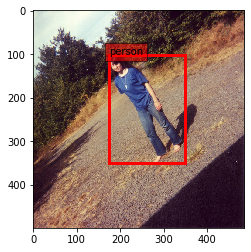

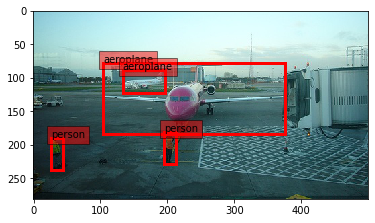

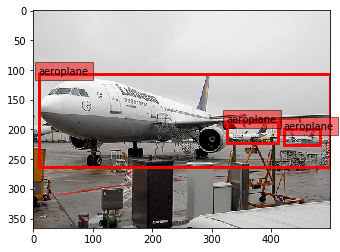

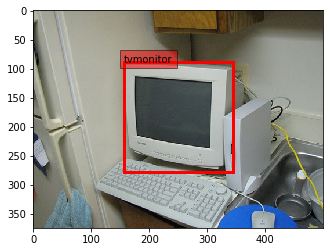

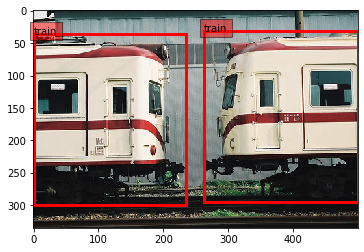

In [164]:
def plot(df_id, bounding_boxes=True, bb_centers=False):
    im = Image.open(os.path.join('../data/raw/VOC2012/JPEGImages', df['filename'][df_id]))
    
    plt.imshow(im)
    
    # Get the current reference
    ax = plt.gca()

    for obj in df['object'][df_id]:
        xmin = int(obj['bndbox']['xmin'])
        ymin = int(obj['bndbox']['ymin'])
        xmax = int(obj['bndbox']['xmax'])
        ymax = int(obj['bndbox']['ymax'])
        width = xmax - xmin
        height = ymax - ymin
        center_x = (xmax + xmin)/2
        center_y = (ymax + ymin)/2
        
        if bounding_boxes:
            rect = Rectangle((xmin,ymin), width, height, fill=False, linewidth=3,edgecolor='r')
            plt.text(xmin, ymin,obj['name'], bbox=dict(facecolor='red', alpha=0.5))
            ax.add_patch(rect)
        
        if bb_centers:
            c = Circle((center_x, center_y), radius=5, color='r' )
            ax.add_patch(c)
            plt.plot(center_x, center_y,markersize=100)
    plt.show()
    
for i in range(5):
    plot(i)

## Size of images


Next cell shows distribution of image sizes. Most images have at least one side size equal to 500 pixels


              width        height    depth
count  17125.000000  17125.000000  17125.0
mean     466.797547    389.507620      3.0
std       61.931367     65.497125      0.0
min      142.000000     71.000000      3.0
25%      499.000000    338.000000      3.0
50%      500.000000    375.000000      3.0
75%      500.000000    400.000000      3.0
max      500.000000    500.000000      3.0


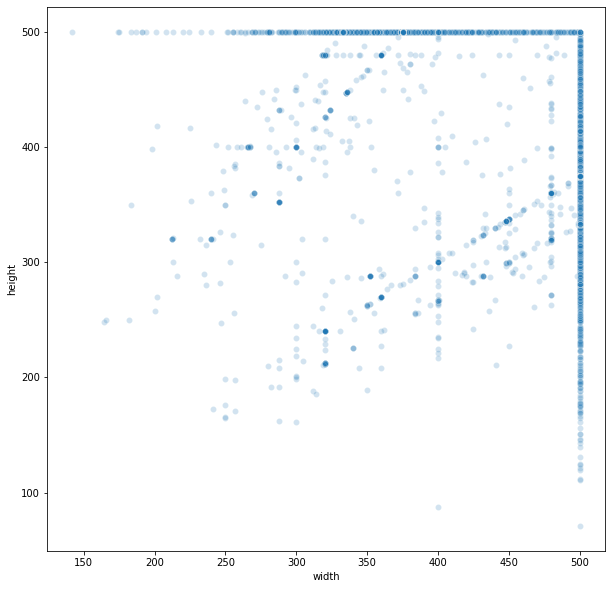

In [49]:
print(df[['width', 'height', 'depth']].describe())

plt.figure(figsize=(10,10))
ax = sns.scatterplot('width', 'height', data=df, alpha=0.2)


## Number of objects on images

Next cell shows distribution of count of objects on images. Each image has at least one object on it. Majority of images have less than 12 objects.

count    17125.000000
mean         2.343825
std          2.421888
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
95%          7.000000
99%         12.000000
max         56.000000
Name: object_count, dtype: float64


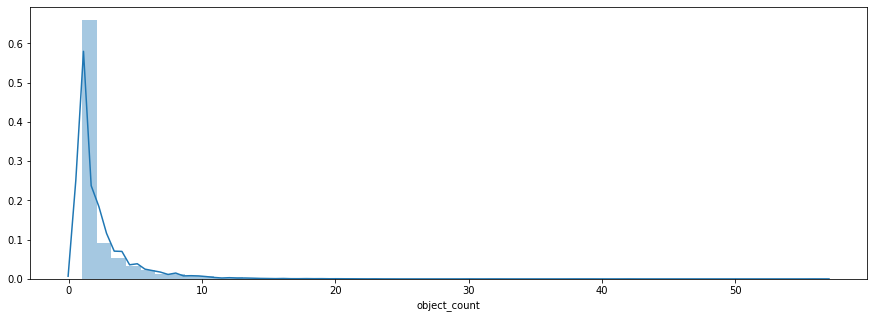

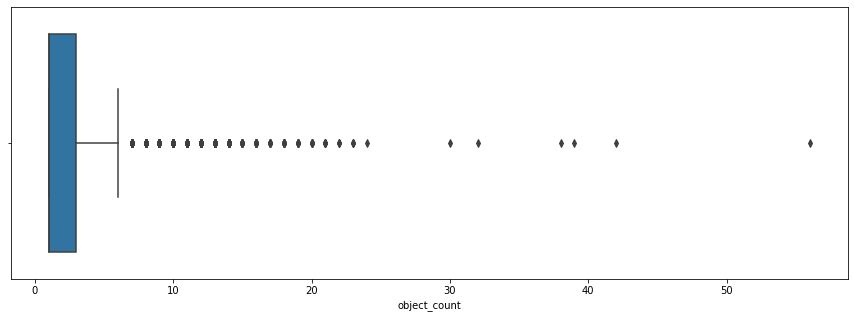

In [50]:
print(df['object_count'].describe(percentiles=[.25,.5,.75,.95,.99]))

plt.figure(figsize=(15,5))
sns.distplot(df['object_count'])
plt.show()
plt.figure(figsize=(15,5))
sns.boxplot(df['object_count'])
plt.show()

## Bounding boxes on images

In [142]:
objects = pd.io.json.json_normalize(np.hstack(df['object'].values))

for col in ['bndbox.xmin','bndbox.xmax','bndbox.ymin','bndbox.ymax']:
    objects[col] = objects[col].astype(float)
    
objects = objects.join(df,rsuffix='img.', on = pd.Series(np.hstack((df.img_id.apply(lambda x: [x]) * df.object_count).values)))

In [143]:
objects['x'] = (objects['bndbox.xmin'] + objects['bndbox.xmax'])/2 / objects['width']
objects['y'] = (objects['bndbox.ymin'] + objects['bndbox.ymax'])/2 / objects['height']

objects['bb_width'] = (objects['bndbox.xmax'] - objects['bndbox.xmin']) / objects['width']
objects['bb_height'] = (objects['bndbox.ymax'] - objects['bndbox.ymin']) / objects['height']



In [144]:
objects.head()

,name,pose,truncated,difficult,part,bndbox.xmin,bndbox.ymin,bndbox.xmax,bndbox.ymax,occluded,...,depth,database,annotation,image,object_count,img_id,x,y,bb_width,bb_height
0,person,Unspecified,0,0,"[{'name': 'head', 'bndbox': {'xmin': '169', 'y...",174.0,101.0,349.0,351.0,NaN,...,3,The VOC2007 Database,PASCAL VOC2007,flickr,1,0,0.538066,0.452000,0.360082,0.500000
1,aeroplane,Frontal,0,0,NaN,104.0,78.0,375.0,183.0,NaN,...,3,The VOC2007 Database,PASCAL VOC2007,flickr,4,1,0.479000,0.464413,0.542000,0.373665
2,aeroplane,Left,0,0,NaN,133.0,88.0,197.0,123.0,NaN,...,3,The VOC2007 Database,PASCAL VOC2007,flickr,4,1,0.330000,0.375445,0.128000,0.124555
3,person,Rear,0,0,NaN,195.0,180.0,213.0,229.0,NaN,...,3,The VOC2007 Database,PASCAL VOC2007,flickr,4,1,0.408000,0.727758,0.036000,0.174377
4,person,Rear,0,0,NaN,26.0,189.0,44.0,238.0,NaN,...,3,The VOC2007 Database,PASCAL VOC2007,flickr,4,1,0.070000,0.759786,0.036000,0.174377


### Position of bouding boxes

Next graph shows coordinates of centers of bounding boxes relative to image size. As we can see, bounding boxes centers are more likely to be located near the center of the image. Top and bottom parts of image are less likely to contain an object center.

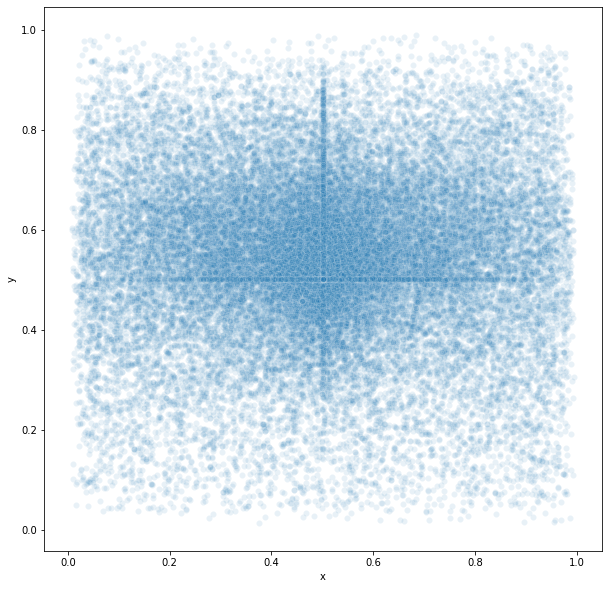

In [145]:
plt.figure(figsize=(10,10))
sns.scatterplot('x', 'y', data=objects, alpha=0.1)

### Size of bounding boxes

Next graph shows sizes of object bounding boxes relative to image size. We can see, that bounding boxes tend to be more vertical.

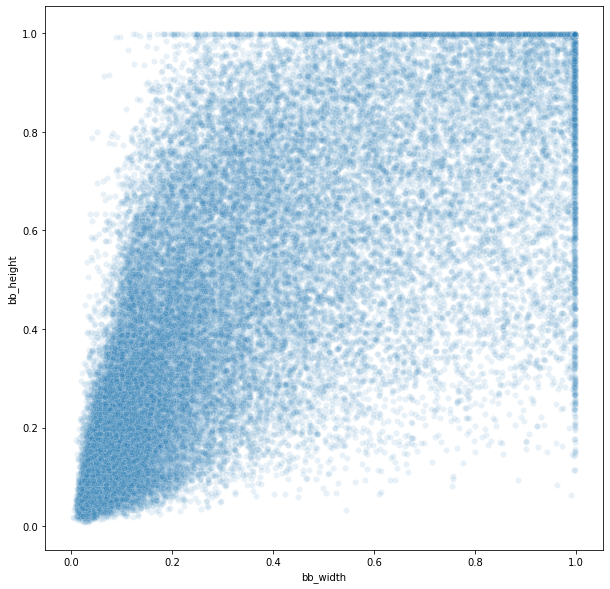

In [168]:
plt.figure(figsize=(10,10))
sns.scatterplot('bb_width', 'bb_height', data=objects, alpha=0.1)

As we can see on a graph above, some of objects can be pretty large - they can cover most of image. Let's take a look at examples of images like these.

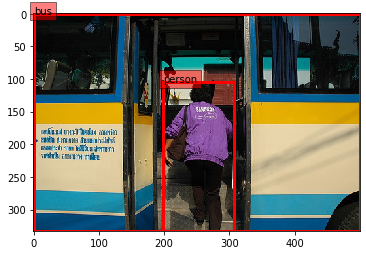

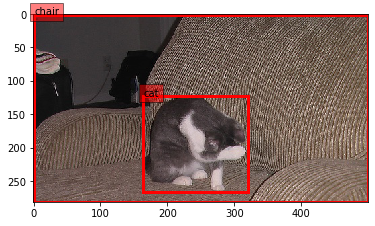

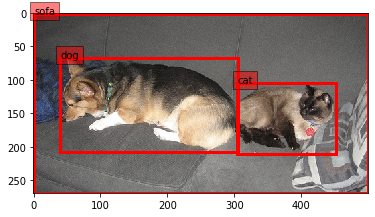

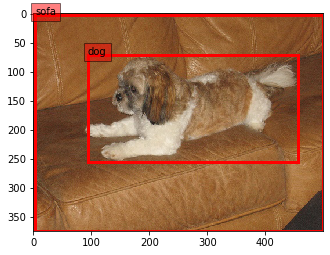

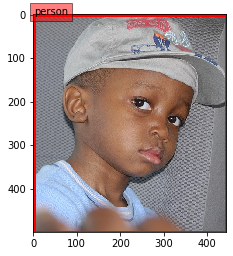

In [169]:
for img_id in objects[(objects['bb_width']>0.99)&(objects['bb_height']>0.99)]['img_id'].values[:5]:
    plot(img_id)